In [71]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns



def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimensiㄴon
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

# standardize features using training statistics (keep split as-is)
mu = X_train.mean(axis=(0,1), keepdims=True)
sigma = X_train.std(axis=(0,1), keepdims=True) + 1e-8
X_train = ((X_train - mu) / sigma).astype('float32')
X_val = ((X_val - mu) / sigma).astype('float32')
testX = ((testX - mu) / sigma).astype('float32')
X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

C:\Users\이예일\AppData\Local\Temp\ipykernel_14524\2308141114.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
C:\Users\이예일\AppData\Local\Temp\ipykernel_14524\2308141114.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
C:\Users\이예일\AppData\Local\Temp\ipykernel_14524\2308141114.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
C:\Users\이예일\AppData\Local\Temp\ipykernel_14524\2308141114.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


C:\Users\이예일\AppData\Local\Temp\ipykernel_14524\2308141114.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [72]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [73]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout,
    Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    BatchNormalization, ReLU, concatenate
)

## Multi-scale CNN with global average pooling head
inputs = Input(shape=(n_timesteps,n_features))
x = Conv1D(filters=128, kernel_size=5, activation=None, padding='same')(inputs)
x = BatchNormalization()(x); x = ReLU()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.2)(x)

x = Conv1D(filters=64, kernel_size=5, activation=None, padding='same')(x)
x = BatchNormalization()(x); x = ReLU()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.2)(x)

# multi-scale branches capture different temporal contexts
branch_small = Conv1D(64, kernel_size=3, padding='same')(x)
branch_small = BatchNormalization()(branch_small); branch_small = ReLU()(branch_small)

branch_wide = Conv1D(64, kernel_size=9, padding='same')(x)
branch_wide = BatchNormalization()(branch_wide); branch_wide = ReLU()(branch_wide)

branch_dilated = Conv1D(64, kernel_size=3, dilation_rate=3, padding='same')(x)
branch_dilated = BatchNormalization()(branch_dilated); branch_dilated = ReLU()(branch_dilated)

multi_scale = concatenate([branch_small, branch_wide, branch_dilated], axis=-1)

x = GlobalAveragePooling1D()(multi_scale)
x = Dropout(0.4)(x)
dense = Dense(128, activation='relu')(x)
outputs = Dense(n_outputs, activation='softmax')(dense)
cnn3_model = Model(inputs, outputs)
cnn3_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn3_model.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_50 (Conv1D)  │ (None, 128, 128)  │      5,888 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_50[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_50 (ReLU)     │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_20    │ (None, 64, 128)   │          0 │ re_lu_50[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 64, 128)   │          0 │ max_pooling1d_20… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_51 (Conv1D)  │ (None, 64, 64)    │     41,024 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_51[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_51 (ReLU)     │ (None, 64, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_21    │ (None, 32, 64)    │          0 │ re_lu_51[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 32, 64)    │          0 │ max_pooling1d_21… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_52 (Conv1D)  │ (None, 32, 64)    │     12,352 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_53 (Conv1D)  │ (None, 32, 64)    │     36,928 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_54 (Conv1D)  │ (None, 32, 64)    │     12,352 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64)    │        256 │ conv1d_52[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64)    │        256 │ conv1d_53[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64)    │        256 │ conv1d_54[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_52 (ReLU)     │ (None, 32, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_53 (ReLU)     │ (None, 32, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_54 (ReLU)     │ (None, 32, 64)    │          0 │ batch_normalizat

 Total params: 135,558 (529.52 KB)

 Trainable params: 134,790 (526.52 KB)

 Non-trainable params: 768 (3.00 KB)

In [74]:
model_history=cnn3_model.fit(
    x=X_train,
    y=y_train_one_hot,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=20, min_delta=1e-4, restore_best_weights=True)]
)


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7229 - loss: 0.7120 - val_accuracy: 0.9389 - val_loss: 0.1810
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9449 - loss: 0.1430 - val_accuracy: 0.9423 - val_loss: 0.1256
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9479 - loss: 0.1312 - val_accuracy: 0.9525 - val_loss: 0.1041
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9460 - loss: 0.1297 - val_accuracy: 0.9610 - val_loss: 0.0981
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9565 - loss: 0.1112 - val_accuracy: 0.9610 - val_loss: 0.0957
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9538 - loss: 0.1173 - val_accuracy: 0.9559 - val_loss: 0.0964
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9532 - loss: 0.1184 - val_accuracy: 0.9610 - val_loss: 0.0960
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9438 - loss: 0.1370 - val_accuracy: 0.9542 - v

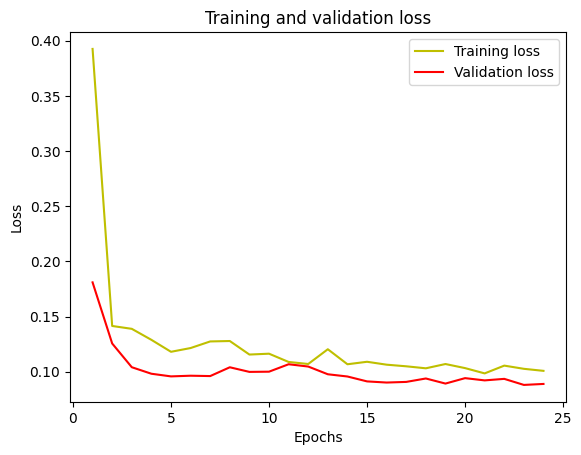

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
     

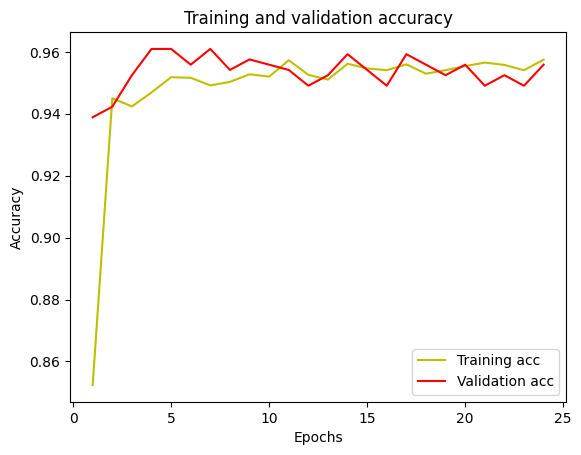

In [76]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[493   1   2   0   0   0]
 [  2 449  20   0   0   0]
 [  0   0 420   0   0   0]
 [  0   1   0 377 111   2]
 [  0   0   0  60 472   0]
 [  0   0   0   0   0 537]]
0.9324737020699015
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       496
           1       1.00      0.95      0.97       471
           2       0.95      1.00      0.97       420
           3       0.86      0.77      0.81       491
           4       0.81      0.89      0.85       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.94      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



<Axes: >

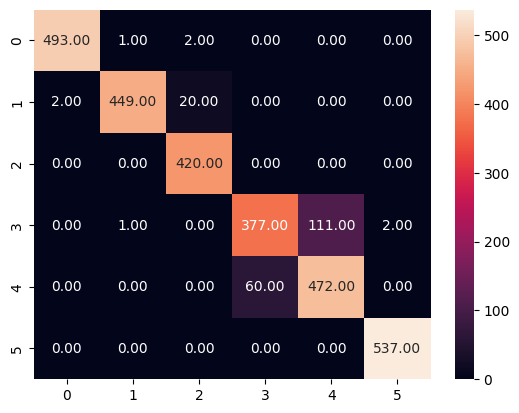

In [77]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=cnn3_model.predict(testX)
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm) 
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')